In [1]:
from dataclasses import dataclass, asdict
from collections import Counter
import random
from typing import Optional, Any, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from scipy.stats import gaussian_kde

from tqdm.auto import tqdm

import utilities.plotting_style as pstyle

pstyle.apply_style() 

/Users/yannisvassiliadis/code/playground/projects/panini_stickers/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PlotFonts(base=None, bold=None)

In [2]:
@dataclass(frozen=True)
class StickerSimParams:
    len_album: int
    free_stickers: int
    len_packet: int
    packet_price: float
    postage_cost: float
    order_stickers: int
    max_trade: int
    min_trade: float
    exchange_efficiency: float
    batch_size: int = 1
    max_trades_per_cycle: Optional[int] = 3


class StickerSim:
    def __init__(
        self,
        params: StickerSimParams,
        n_simulations: int,
        seed: Optional[int] = None,
    ):
        self.params = params
        self.n_simulations = n_simulations
        self.seed = seed

        self.results_df: Optional[pd.DataFrame] = None

    # -------- core simulation internals (same substance) --------
    def _init_state(self, rng: random.Random) -> Dict[str, Any]:
        p = self.params
        all_stickers = list(range(p.len_album))

        album = set(rng.sample(all_stickers, p.free_stickers))
        dupes = Counter()

        return {
            "all_stickers": all_stickers,
            "album": album,
            "dupes": dupes,
            "n_packets": 0,
            "n_trades": 0,
            "cost_packets": 0.0,
            "cost_postage": 0.0,
            "stickers_from_packets": 0,
            "stickers_from_trade": 0,
            "packet_gains": [],
            "trade_gains_after_packet": [],
            "missing_count": p.len_album - len(album),
        }

    def _buy_and_apply_packets(self, state: Dict[str, Any], rng: random.Random) -> None:
        p = self.params
        album = state["album"]
        dupes: Counter = state["dupes"]
        all_stickers = state["all_stickers"]

        for _ in range(p.batch_size):
            packet = rng.sample(all_stickers, p.len_packet)
            state["n_packets"] += 1
            state["cost_packets"] += p.packet_price

            new_dupes = [s for s in packet if s in album]
            dupes.update(new_dupes)
            album.update(packet)

            packet_gain = p.len_packet - len(new_dupes)
            state["stickers_from_packets"] += packet_gain
            state["packet_gains"].append(packet_gain)
            state["trade_gains_after_packet"].append(0)

        state["missing_count"] = p.len_album - len(album)

    def _can_trade_now(self, dupes: Counter) -> bool:
        p = self.params
        total_dupes = len(dupes)  # distinct dupes
        return total_dupes >= (p.min_trade / p.exchange_efficiency)

    def _execute_one_trade(self, state: Dict[str, Any], rng: random.Random) -> bool:
        p = self.params
        album = state["album"]
        dupes: Counter = state["dupes"]
        all_stickers = state["all_stickers"]
        missing_count = state["missing_count"]

        if missing_count <= p.order_stickers:
            return False

        if not self._can_trade_now(dupes):
            return False

        total_dupes = len(dupes)
        trade_size = min(rng.choice(range(1, total_dupes + 1)), p.max_trade, missing_count)

        still_missing = list(set(all_stickers) - album)
        trade_size = min(trade_size, len(still_missing))

        if trade_size <= 0:
            return False

        new_from_trade = rng.sample(still_missing, trade_size)
        trade_away = rng.sample(list(dupes.keys()), trade_size)

        state["cost_postage"] += p.postage_cost
        state["n_trades"] += 1

        trade_gain = len(new_from_trade)
        state["stickers_from_trade"] += trade_gain

        if state["trade_gains_after_packet"]:
            state["trade_gains_after_packet"][-1] += trade_gain

        album.update(new_from_trade)
        dupes.subtract(trade_away)
        state["dupes"] = dupes + Counter()

        state["missing_count"] = p.len_album - len(album)
        return True

    def _trade_after_buy(self, state: Dict[str, Any], rng: random.Random) -> None:
        p = self.params
        if p.max_trades_per_cycle is None:
            while True:
                if not self._execute_one_trade(state, rng):
                    break
            return

        for _ in range(p.max_trades_per_cycle):
            if not self._execute_one_trade(state, rng):
                break

    @staticmethod
    def _compute_crossover_indices(packet_gains: List[int], trade_gains_after_packet: List[int]):
        delta = [t - pg for pg, t in zip(packet_gains, trade_gains_after_packet)]
        start_trade_idx = next((i for i, d in enumerate(delta) if d >= 0), None)
        last_buy_dominant_idx = next((i for i in range(len(delta) - 1, -1, -1) if delta[i] < 0), None)
        return start_trade_idx, last_buy_dominant_idx

    def _simulate_one(self, rng: random.Random) -> Dict[str, Any]:
        p = self.params
        state = self._init_state(rng)

        while state["missing_count"] > p.order_stickers:
            self._buy_and_apply_packets(state, rng)
            self._trade_after_buy(state, rng)

        start_trading, stop_buying = self._compute_crossover_indices(
            state["packet_gains"], state["trade_gains_after_packet"]
        )

        total_ordered = p.len_album - state["stickers_from_packets"] - state["stickers_from_trade"] - p.free_stickers

        record = {
            **asdict(p),  # include params in every row
            "num_packets": state["n_packets"],
            "buy_cost": state["cost_packets"],
            "total_from_packets": state["stickers_from_packets"],
            "num_trades": state["n_trades"],
            "trade_cost": state["cost_postage"],
            "total_from_trades": state["stickers_from_trade"],
            "total_cost": state["cost_packets"] + state["cost_postage"],
            "total_ordered": total_ordered,
            "start_trading": start_trading,
            "stop_buying": stop_buying,
            # keep timelines out of df by default; add if you want debugging later
        }
        return record

    # -------- public API --------
    def run(self, *, show_progress: bool = True) -> pd.DataFrame:
        rng_master = random.Random(self.seed)
        rows = []

        it = range(self.n_simulations)
        if show_progress:
            it = tqdm(it, total=self.n_simulations, desc="Simulations", unit="sim")

        for _ in it:
            sim_seed = rng_master.randrange(1_000_000_000) if self.seed is not None else None
            rng = random.Random(sim_seed)
            rows.append(self._simulate_one(rng))

        self.results_df = pd.DataFrame(rows)
        return self.results_df

    def best_pairs(self, top_n: int = 5, min_count: int = 1) -> pd.DataFrame:
        if self.results_df is None:
            raise ValueError("Run simulations first: call .run()")

        g = (
            self.results_df
            .dropna(subset=["start_trading", "stop_buying", "total_cost"])
            .groupby(["start_trading", "stop_buying"])["total_cost"]
            .agg(mean="mean", median="median", n="count")
            .reset_index()
        )
        g = g[g["n"] >= min_count].sort_values(["mean", "median", "n"], ascending=[True, True, False]).head(top_n)
        return g

    def print_best_pairs_summary(self, top_n: int = 5, min_count: int = 1) -> None:
        bp = self.best_pairs(top_n=top_n, min_count=min_count)
        print(bp.to_string(index=False, justify="left"))

    # -------- plotting methods --------
    def plot_cost_distribution(self) -> None:
        if self.results_df is None:
            raise ValueError("Run simulations first: call .run()")

        df = self.results_df
        mean_cost = df["total_cost"].mean()
        median_cost = df["total_cost"].median()

        fig, ax = plt.subplots()
        ax.hist(df["total_cost"], bins=40)
        ax.axvline(mean_cost, linewidth=1, linestyle="dotted", color="#881C00FF", label=f"Mean: ${mean_cost:,.2f}")
        ax.axvline(median_cost, linewidth=1, linestyle="dashed", color="#1BB6AFFF", label=f"Median: ${median_cost:,.2f}")

        pstyle.set_title(ax, "Distribution of Total Cost", f"(based on {self.n_simulations:,} simulations)")
        ax.set_xlabel("Total Cost ($)")
        ax.set_ylabel("Count")
        ax.legend(frameon=False)
        pstyle.style_plot(ax, format_thousands_axis="x")
        plt.show()

    def plot_trade_timing_kdes(self, bw_method: float = 0.25) -> None:
        if self.results_df is None:
            raise ValueError("Run simulations first: call .run()")

        df = self.results_df.dropna(subset=["start_trading", "stop_buying"])
        x1 = df["start_trading"].to_numpy()
        x2 = df["stop_buying"].to_numpy()

        xmin = min(x1.min(), x2.min())
        xmax = max(x1.max(), x2.max())
        xs = np.linspace(0.9 * xmin if xmin > 0 else xmin - 0.1 * xmax, 1.1 * xmax, 500)

        kde_start = gaussian_kde(x1, bw_method=bw_method)
        kde_stop = gaussian_kde(x2, bw_method=bw_method)

        fig, ax = plt.subplots()
        ax.plot(xs, kde_start(xs), label="Start Trading", color = '#1BB6AFFF')
        ax.plot(xs, kde_stop(xs), label="Stop Buying", color = '#AF6125FF') 

        pstyle.set_title(ax, "Trade Timing Densities", f"(based on {self.n_simulations:,} simulations)")
        ax.set_xlabel("Packet index")
        ax.set_ylabel("Density")
        ax.legend(frameon=False)
        pstyle.style_plot(ax, format_thousands_axis="x")
        plt.show()

    def plot_phase_diagram(self, top_n: int = 5, min_count: int = 1) -> None:
        if self.results_df is None:
            raise ValueError("Run simulations first: call .run()")

        df = self.results_df.dropna(subset=["start_trading", "stop_buying", "total_cost"])

        fig, ax = plt.subplots()
        sc = ax.scatter(df["start_trading"], df["stop_buying"], c=df["total_cost"], alpha=0.3)

        # highlight top-N best pairs (no annotations)
        bp = self.best_pairs(top_n=top_n, min_count=min_count)
        ax.scatter(
            bp["start_trading"],
            bp["stop_buying"],
            s=260,
            facecolors="none",
            edgecolors="black",
            linewidths=2.5,
            zorder=5,
            label=f"Top {top_n} combos (lowest mean cost)",
        )
        ax.scatter(
            bp["start_trading"],
            bp["stop_buying"],
            s=90,
            marker="",
            linewidths=1,
            c="black",
            zorder=4,
        )

        pstyle.set_title(
            ax,
            "Start trading vs stop buying",
            f"Cost assumes ${self.params.packet_price} per packet and ${self.params.postage_cost} per trade. "
            f"Based on {self.n_simulations:,} simulations.",
        )
        ax.set_xlabel("Start trading (# of packets bought)")
        ax.set_ylabel("Stop buying (# of packets bought)")
        ax.legend(frameon=False)
        pstyle.style_plot(ax, format_thousands_axis=None)

        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label("Total cost ($)")
        cbar.ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.2f}"))

        plt.show()


In [3]:
class ParamSweep:
    def __init__(
        self,
        base_params: StickerSimParams,
        n_simulations: int,
        sweep_param: str,           # e.g. "len_album", "batch_size"
        sweep_values: List[Any],
        seed: Optional[int] = None,
    ):
        self.base_params = base_params
        self.n_simulations = n_simulations
        self.sweep_param = sweep_param
        self.sweep_values = sweep_values
        self.seed = seed

        self.results_df: Optional[pd.DataFrame] = None

    def run(self, *, show_progress: bool = True, show_inner: bool = False) -> pd.DataFrame:
        all_rows = []

        sweep_iter = self.sweep_values
        if show_progress:
            sweep_iter = tqdm(self.sweep_values, desc=f"Sweep: {self.sweep_param}", unit="value")

        for v in sweep_iter:
            new_params = StickerSimParams(**{**asdict(self.base_params), self.sweep_param: v})
            sim = StickerSim(new_params, n_simulations=self.n_simulations, seed=self.seed)

            df = sim.run(show_progress=show_inner)  # inner progress optional
            df = df.copy()
            df["sweep_value"] = v  # canonical grouping column for sweep plots
            all_rows.append(df)

        self.results_df = pd.concat(all_rows, ignore_index=True)
        return self.results_df

    # --------- internal ridgeplot implementation ---------
    def _ridgeplot_kde(
        self,
        df: pd.DataFrame,
        *,
        group_col: str,
        value_col: str,
        title: str,
        subtitle: str = "",
        xlabel: Optional[str] = None,
        bw_method=None,
        normalize: bool = True,
        ridge_spacing: float = 1.25,
        ridge_height: float = 0.9,
        label_x_axes: float = 0.01,
        label_y_offset: float = 0.10,
        show_mean: bool = True,
        mean_label: bool = False,
        x_mult_pad: float = 0.10,  # uses xmin*=0.9 and xmax*=1.1 style padding
        group_order: Optional[List[Any]] = None,
        label_fmt=None,  # callable(group_value) -> str
    ) -> None:
        if label_fmt is None:
            label_fmt = lambda g: f"{self.sweep_param}: {g}"

        data = df[[group_col, value_col]].dropna()

        if group_order is None:
            # numeric sort if possible, else string sort
            try:
                groups = sorted(data[group_col].unique(), key=float)
            except Exception:
                groups = sorted(data[group_col].unique(), key=lambda x: str(x))
        else:
            groups = list(group_order)

        vals = data[value_col].to_numpy()
        xmin, xmax = float(np.min(vals)), float(np.max(vals))

        # multiplicative padding (your suggestion)
        xmin_eval = (1.0 - x_mult_pad) * xmin
        xmax_eval = (1.0 + x_mult_pad) * xmax

        # handle xmin == 0 cleanly (avoid xmin_eval == 0 if you want breathing room)
        if xmin == 0:
            xmin_eval = -x_mult_pad * xmax

        xs = np.linspace(xmin_eval, xmax_eval, 600)

        fig, ax = plt.subplots()

        plotted = 0
        for g in groups:
            x = data.loc[data[group_col] == g, value_col].to_numpy()
            if len(x) < 2:
                continue

            kde = gaussian_kde(x, bw_method=bw_method)
            ys = kde(xs)

            if normalize and ys.max() > 0:
                ys = ys / ys.max()

            y0 = plotted * ridge_spacing
            y_curve = y0 + ys * ridge_height

            line, = ax.plot(xs, y_curve, linewidth=1)
            ax.fill_between(xs, y0, y_curve, alpha=0.25)

            # bumped label (x in axes coords, y in data coords)
            ax.text(
                label_x_axes,
                y0 + label_y_offset,
                label_fmt(g),
                va="center",
                ha="left",
                fontsize=11,
                fontweight="bold",
                color=line.get_color(),
                transform=ax.get_yaxis_transform(),
            )

            subtitle2 = subtitle
            if show_mean:
                mu = float(np.mean(x))
                subtitle2 = (subtitle + "  " if subtitle else "") + "Dotted line = mean"
                ax.vlines(
                    mu,
                    y0,
                    y0 + ridge_height,
                    linewidth=1,
                    linestyles="dotted",
                    color=line.get_color(),
                    alpha=0.9,
                )
                if mean_label:
                    ax.text(
                        mu,
                        y0 + ridge_height + 0.05,
                        f"μ={mu:.1f}",
                        ha="center",
                        va="bottom",
                        fontsize=9,
                        color=line.get_color(),
                    )

            plotted += 1

        pstyle.set_title(ax, title, subtitle2)
        ax.set_xlabel(xlabel or value_col)
        ax.set_yticks([])

        if plotted > 0:
            ax.set_ylim(-0.2, (plotted - 1) * ridge_spacing + ridge_height + 0.4)

        ax.set_xlim(xmin_eval, xmax_eval)
        pstyle.style_plot(ax, format_thousands_axis="x")
        plt.show()

    # --------- public ridgeplot API ---------
    def plot_ridgeplot_kde(
        self,
        *,
        value_col: str,
        title: str,
        subtitle: str = "",
        bw_method=None,
        ridge_spacing: float = 1.25,
        ridge_height: float = 0.9,
        group_order: Optional[List[Any]] = None,
        label_fmt=None,  # callable(group_value) -> str
    ) -> None:
        if self.results_df is None:
            raise ValueError("Run sweep first: call .run()")

        df = self.results_df.dropna(subset=["sweep_value", value_col]).copy()

        if label_fmt is None:
            label_fmt = lambda g: f"{self.sweep_param}: {g}"

        self._ridgeplot_kde(
            df,
            group_col="sweep_value",
            value_col=value_col,
            title=title,
            subtitle=subtitle,
            xlabel=value_col,
            bw_method=bw_method,
            ridge_spacing=ridge_spacing,
            ridge_height=ridge_height,
            group_order=group_order,
            label_fmt=label_fmt,
        )

In [4]:
params = StickerSimParams(
    len_album=980,
    free_stickers=6,
    len_packet=7,
    packet_price=0.8,
    postage_cost=0.5,
    order_stickers=50,
    max_trade=10,
    min_trade=4,
    exchange_efficiency=0.1,
    batch_size=1,
    max_trades_per_cycle=3,
)

sim = StickerSim(params, n_simulations=10_000, seed=4)
results_df = sim.run()

results_df.head()

Simulations: 100%|██████████| 10000/10000 [00:18<00:00, 554.30sim/s]


,len_album,free_stickers,len_packet,packet_price,postage_cost,order_stickers,max_trade,min_trade,exchange_efficiency,batch_size,...,num_packets,buy_cost,total_from_packets,num_trades,trade_cost,total_from_trades,total_cost,total_ordered,start_trading,stop_buying
0,980,6,7,0.8,0.5,50,10,4,0.1,1,...,137,109.6,504,46,23.0,422,132.6,48,39,129
1,980,6,7,0.8,0.5,50,10,4,0.1,1,...,138,110.4,531,47,23.5,397,133.9,46,46,136
2,980,6,7,0.8,0.5,50,10,4,0.1,1,...,137,109.6,530,44,22.0,396,131.6,48,43,134
3,980,6,7,0.8,0.5,50,10,4,0.1,1,...,137,109.6,522,45,22.5,407,132.1,45,46,134
4,980,6,7,0.8,0.5,50,10,4,0.1,1,...,138,110.4,530,44,22.0,399,132.4,45,42,135


 start_trading  stop_buying  mean       median  n 
49             134          132.297222 132.1    36
48             134          132.316981 132.1    53
46             129          132.443750 132.4    32
48             131          132.458824 132.4    34
46             134          132.476033 132.4   121


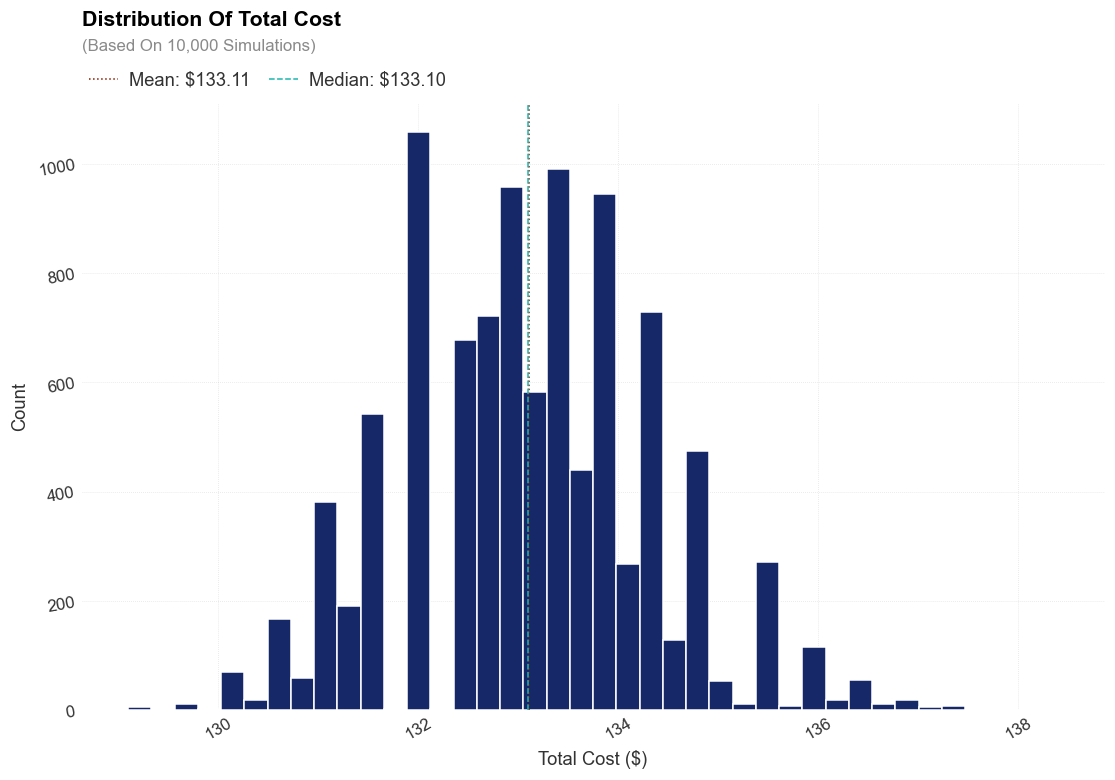

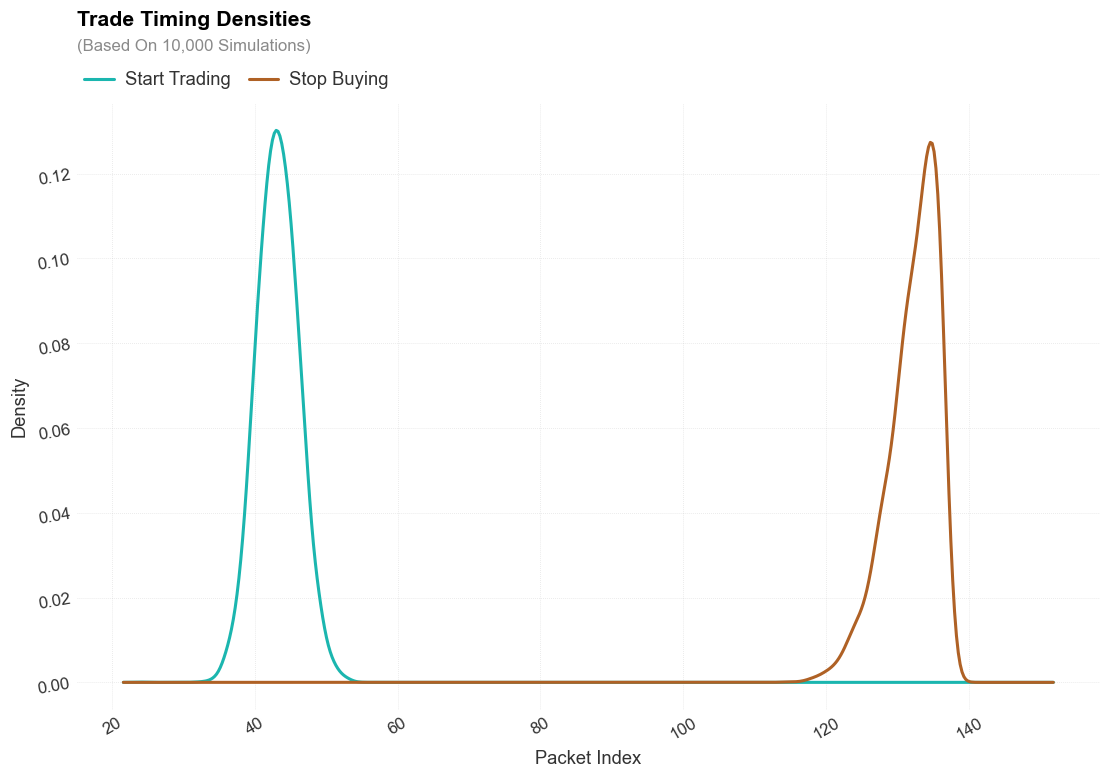

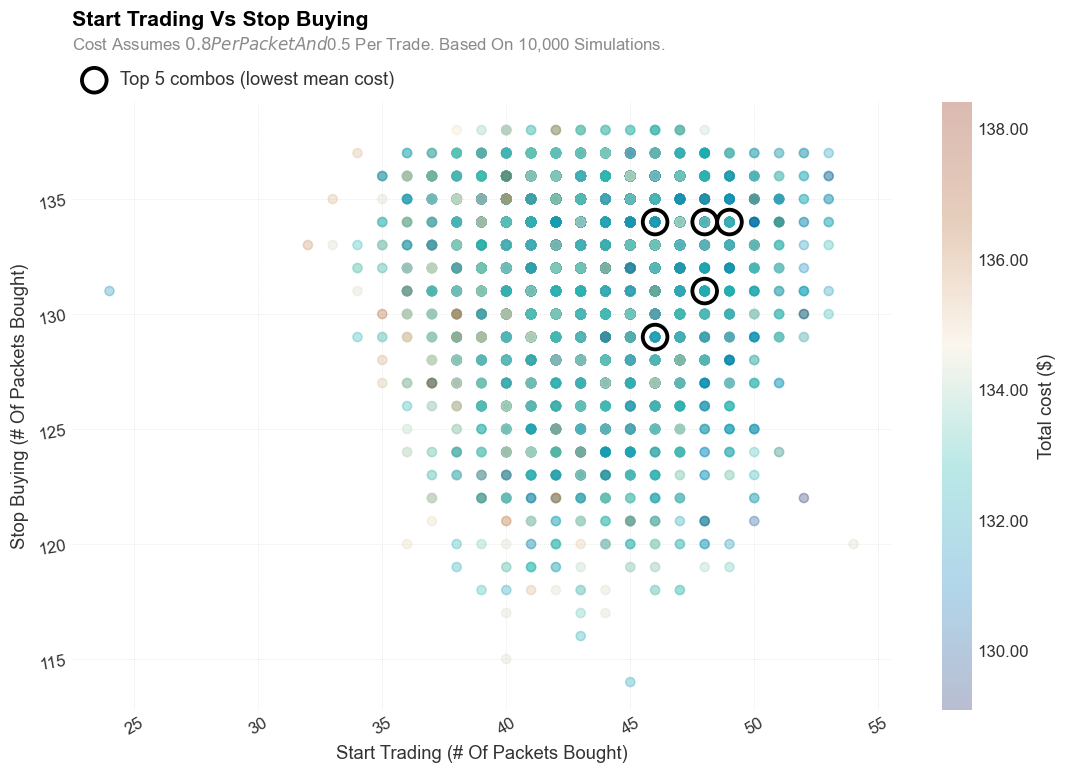

,start_trading,stop_buying,mean,median,n
319,52,122,129.100000,129.10,1
292,50,121,130.100000,130.10,1
323,52,132,131.100000,131.10,1
334,53,136,131.150000,131.15,2
304,50,134,131.185714,131.10,7


In [5]:
sim.print_best_pairs_summary(top_n=5, min_count=30)
sim.plot_cost_distribution()
sim.plot_trade_timing_kdes()
sim.plot_phase_diagram(top_n=5, min_count=30)
sim.best_pairs()

In [6]:
sweep = ParamSweep(
    base_params=params,
    n_simulations=2000,
    sweep_param="batch_size",
    sweep_values=[1, 2, 5, 10, 20],
    seed=31,
)

sweep_df = sweep.run()
sweep_df.head()

Sweep: batch_size: 100%|██████████| 5/5 [00:18<00:00,  3.71s/value]


,len_album,free_stickers,len_packet,packet_price,postage_cost,order_stickers,max_trade,min_trade,exchange_efficiency,batch_size,...,buy_cost,total_from_packets,num_trades,trade_cost,total_from_trades,total_cost,total_ordered,start_trading,stop_buying,sweep_value
0,980,6,7,0.8,0.5,50,10,4,0.1,1,...,109.6,526,46,23.0,399,132.6,49,40,123,1
1,980,6,7,0.8,0.5,50,10,4,0.1,1,...,109.6,514,45,22.5,411,132.1,49,40,132,1
2,980,6,7,0.8,0.5,50,10,4,0.1,1,...,109.6,512,50,25.0,416,134.6,46,43,133,1
3,980,6,7,0.8,0.5,50,10,4,0.1,1,...,109.6,511,49,24.5,413,134.1,50,42,135,1
4,980,6,7,0.8,0.5,50,10,4,0.1,1,...,109.6,505,45,22.5,419,132.1,50,38,135,1


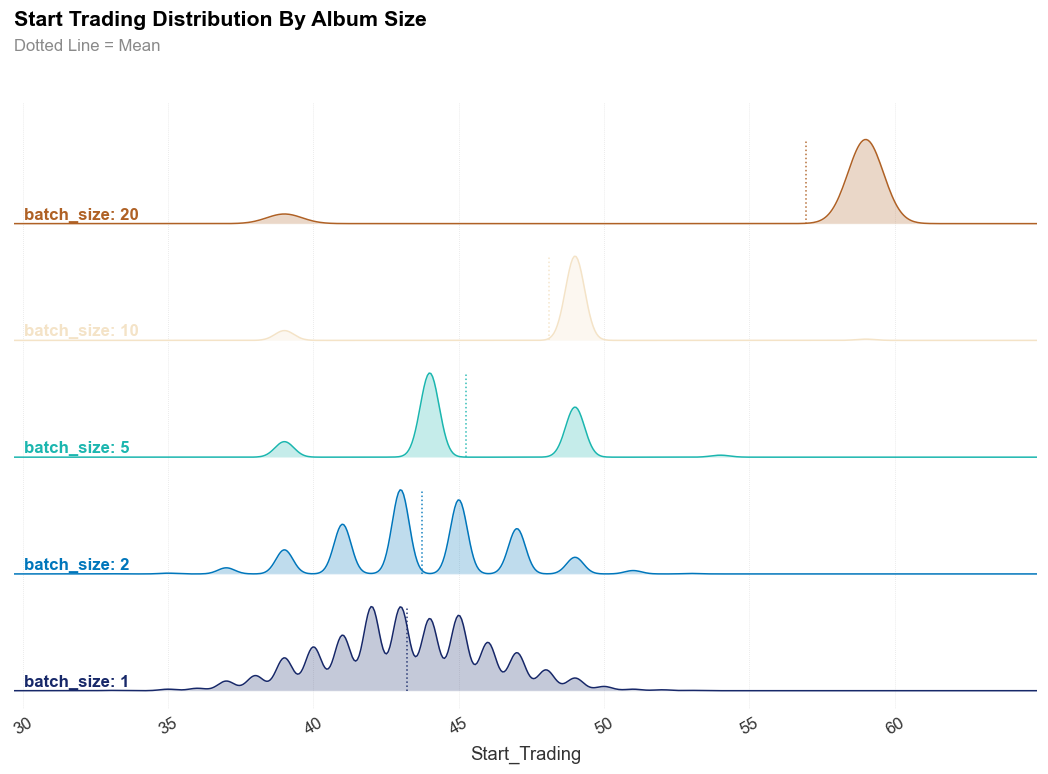

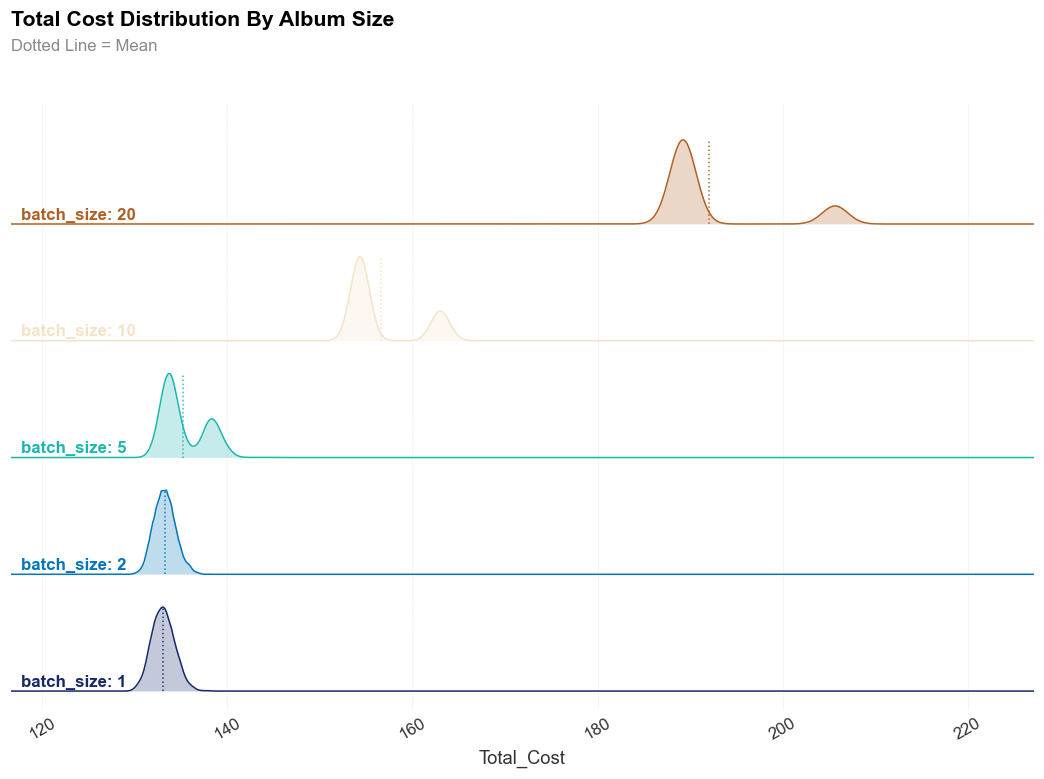

In [7]:
sweep.plot_ridgeplot_kde(
    value_col="start_trading",
    title="Start trading distribution by album size",
    bw_method=0.10,
)

sweep.plot_ridgeplot_kde(
    value_col="total_cost",
    title="Total cost distribution by album size",
)